# MFN decomposition on a tiny HRRP set
This notebook loads `data/ship_hrrp.pt`, applies MFN decomposition on two HRRP traces, and computes MSE (and cosine) between the filtered components.
Just change indices `idx_a` / `idx_b` to explore other samples.

In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from utils import mfn_decomposition_2D, f_mse, get_df_RP_length

# Data file
data_path = Path('data/ship_hrrp.pt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = torch.load(data_path, map_location=device)
hrrps = dataset['hrrps'].to(device)
aspect_angles = dataset['aspect_angles'].to(device)
ship_dims = dataset['ship_dims'].to(device)

print('HRRPs:', hrrps.shape)
print('Aspect angles:', aspect_angles.shape)
print('Ship dims:', ship_dims.shape)

HRRPs: torch.Size([128, 512])
Aspect angles: torch.Size([128])
Ship dims: torch.Size([128, 2])


/tmp/ipykernel_46980/686432225.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(data_path, map_location=device)


In [2]:
# Choose two samples to compare
idx_a, idx_b = 0, 1  # change these indices to explore

pair = hrrps[[idx_a, idx_b]].clone()
print('Selected indices:', idx_a, idx_b)
print('Profile length:', pair.shape[1])

Selected indices: 0 1
Profile length: 512


In [3]:
# MFN decomposition
sigma = 1.5
kernel_size = 17

lpf, f_comp, n_comp = mfn_decomposition_2D(pair, sigma=sigma, kernel_size=kernel_size)

# Binary mask of detected target (used to normalize MSE)
lengths, starts, ends = get_df_RP_length(pair, tresh=0.5, return_first_last=True)
mask = torch.zeros_like(pair)
for i in range(pair.shape[0]):
    mask[i, starts[i]:ends[i]] = 1

print('Detected lengths:', lengths.tolist())
print('Bounds (start, end):', list(zip(starts.tolist(), ends.tolist())))

Detected lengths: [152, 80]
Bounds (start, end): [(17, 169), (16, 96)]


In [4]:
# MSE and cosine on f component between the two samples
mse_vals, cosine_vals = f_mse(f_comp[[0]], mask[[0]], f_comp[[1]], mask[[1]])

print('MSE (f):', round(mse_vals.item(), 4))
print('Cosine (f):', round(cosine_vals.item(), 4))

MSE (f): 6.1316
Cosine (f): 0.7355


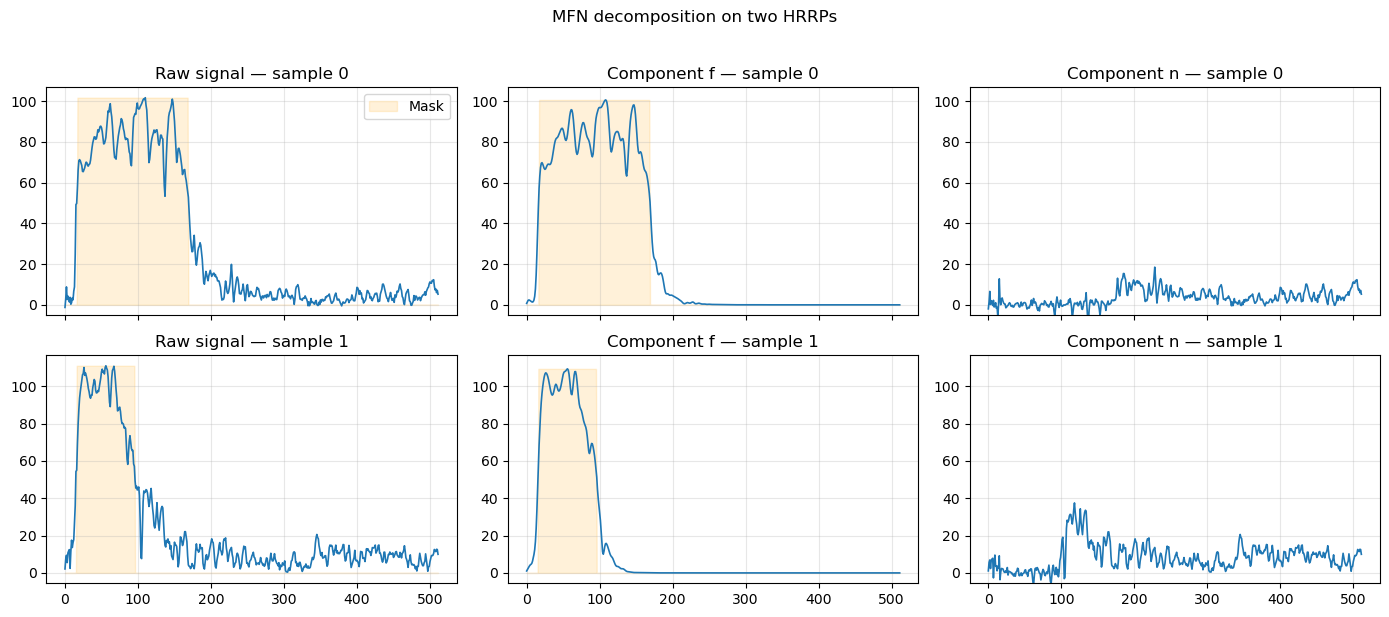

In [7]:
# Quick visualization
fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharex=True)

signals = [pair, f_comp, n_comp]
titles = ['Raw signal', 'Component f', 'Component n']
idxs = [idx_a, idx_b]

for row in range(2):
    ymax = 0.0
    for arr in signals:
        ymax = max(ymax, arr[row].detach().max().item())
    ylims = (-0.05 * ymax, 1.05 * ymax)

    for col, arr in enumerate(signals):
        ax = axes[row, col]
        ax.plot(arr[row].detach().cpu().numpy(), lw=1.2)
        if col !=2:
            ax.fill_between(
                range(arr.shape[1]),
                0,
                mask[row].detach().cpu().numpy() * float(arr[row].max().detach().cpu()),
                color='orange', alpha=0.15,
                label='Mask' if row == 0 and col == 0 else None,
            )
        ax.set_title('{} — sample {}'.format(titles[col], idxs[row]))
        ax.set_ylim(*ylims)
        ax.grid(True, alpha=0.3)

if axes[0,0].get_legend_handles_labels()[0]:
    axes[0,0].legend()

fig.suptitle('MFN decomposition on two HRRPs', y=1.02)
plt.tight_layout()
plt.show()